# Tutorial (Part 2): Learning Module
This tutorial should be run after the first tutorial (`Tutorial_1_Data_Handling.ipynb`).

This tutorial illustrates the usage of the `reasoning` module. The models are primarily defined in `reasoning`. The major functions are implemented in `reasoning/cell_niche_significance.py` (cell niche scoring), `reasoning/cca_model` (sparse CCA implementation / model), and `reasoning/tcn_analysis` (TCN analysis).

In [1]:
import os
import time
import csv, pickle
import re
from tqdm.notebook import tqdm as tqdm
from functools import partial
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
import umap

import numpy as np
import pandas as pd

import torch
import torch_geometric

In [2]:
import SORBET
import SORBET.data_handling as data_handling
import SORBET.learning as learning
import SORBET.reasoning as reasoning

In [3]:
cmap_bwr_upd = matplotlib.colors.LinearSegmentedColormap.from_list('bwr_gi', ['#1A99D5','#DCDCDC', '#DCDCDC','#EE2B5E'])
cmap_pugr_upd = matplotlib.colors.LinearSegmentedColormap.from_list('bwr_gi', ['#45B86A','#DCDCDC', '#DCDCDC', '#A45CA4'])

In [4]:
reasoning_dir = os.path.join(os.getcwd(), "outputs", "tutorial", "reasoning")
if not os.path.exists(reasoning_dir): os.makedirs(reasoning_dir)
record = reasoning.create_data_split_record(reasoning_dir)

## Train a Model on All Data:

For biological reasoning, we train a single model on all available data. First, we need to identify the right set of parameters for inferring 

In [22]:
labels_fpath = "data/tutorial/labels.csv"
root_fpath = os.path.abspath("./")
metadata_files = learning.make_subgraph_metadata("data/tutorial/processed_subgraphs/znormalized/")

In [19]:
labels_fpath = "data/tutorial/labels.csv"
root_fpath = os.path.abspath("./")
metadata_files = learning.make_subgraph_metadata("data/tutorial/processed_subgraphs/znormalized/")

# Create a single TorchOmicsDataset object to train all 
graph_ids = [
    'run_5612_fov_1', 
    'run_5612_fov_2', 
    'run_5612_fov_3', 
    'run_5612_fov_4',
    'run_5612_fov_5',
    'run_5612_fov_6',
    'run_5612_fov_7',
    'run_5612_fov_8', 
    'run_5612_fov_9',
    'run_5612_fov_11'
]

combined_ds = learning.TorchOmicsDataset(root_fpath, metadata_files, graph_ids)

In [33]:
device = torch.device("cuda:2") # Choose specific GPU to train model:

model_structure = {
    'in_channel': 960,
    'random_seed': 50,
    'in_linear_channels': [96],
    'conv_channels': [96, 96, 96],
    'embedding_linear_channels': [192, 96],
    'out_linear_channels': [48],
    'dropout': 0.3,
    'pooling_fn': 'global_max',
    'l1_penalty': 0, # Ignored by model
    'topk_pooling': 0 # Ignored by model
}

params = {
    'epochs': 25, 
    'learning_rate': 0.003,
    'batch_size': 500, # Larger than max batch => Single Batch
    'restarts': 1,
    'validate_step': 25 # No cross validation necessary
}

model_type = learning.GCNSorbetBase

model, (preds, labels), scores, train_loss, val_loss  = learning.train_model(
    model_type, model_structure, [combined_ds, combined_ds], 
    **params, print_lvl=0, device=device, progressbar=True, tensorboard_dir=None
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  7.87it/s]


From the combined model, we now compute the inferred cell and subgraph embeddings. These embeddings are computed via two helper functions: `reasoning.load_model_subgraph_embeddings` and `reasoning.load_model_cell_embeddings`.

In [34]:
subgraph_embeddings_fpath = os.path.join(record.embeddings_dir, "subgraph_embedding.npz")
reasoning.load_model_subgraph_embeddings(model, combined_ds, ofpath = subgraph_embeddings_fpath);

cell_embeddings_fpath = os.path.join(record.embeddings_dir, "cell_embedding.npz")
reasoning.load_model_cell_embeddings(model, combined_ds, metadata_files.processed_dirpath, ofpath = cell_embeddings_fpath);  

# Cell Niche Analysis:
Next we will explore the inferred embeddings of the cell niches and subgraphs. This will lead to the inverse-distance weighted scoring algorithm that compares the embeddings 

### Cell Niche Embedding:
Data exploration for the cell niche emebdding. Identifies the appropriate number of principle components and a UMAP embedding of the cell niches. 

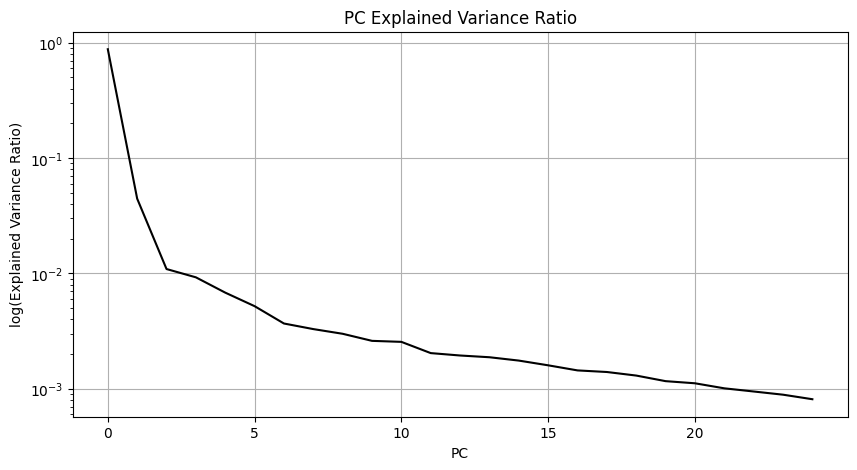

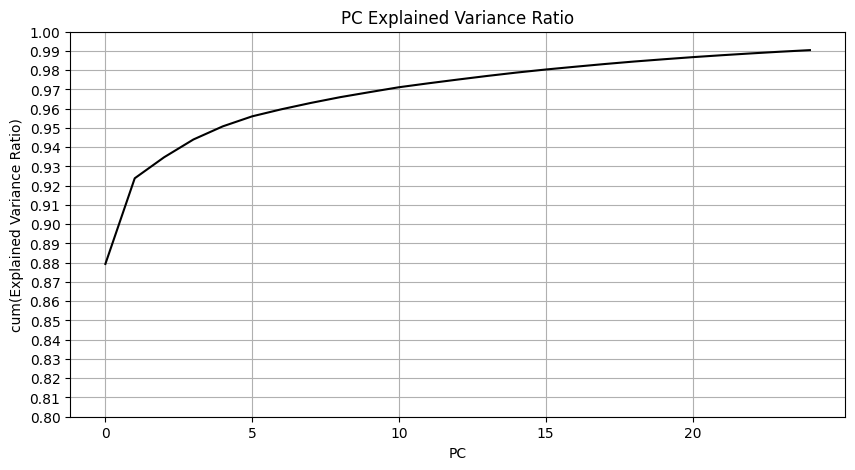

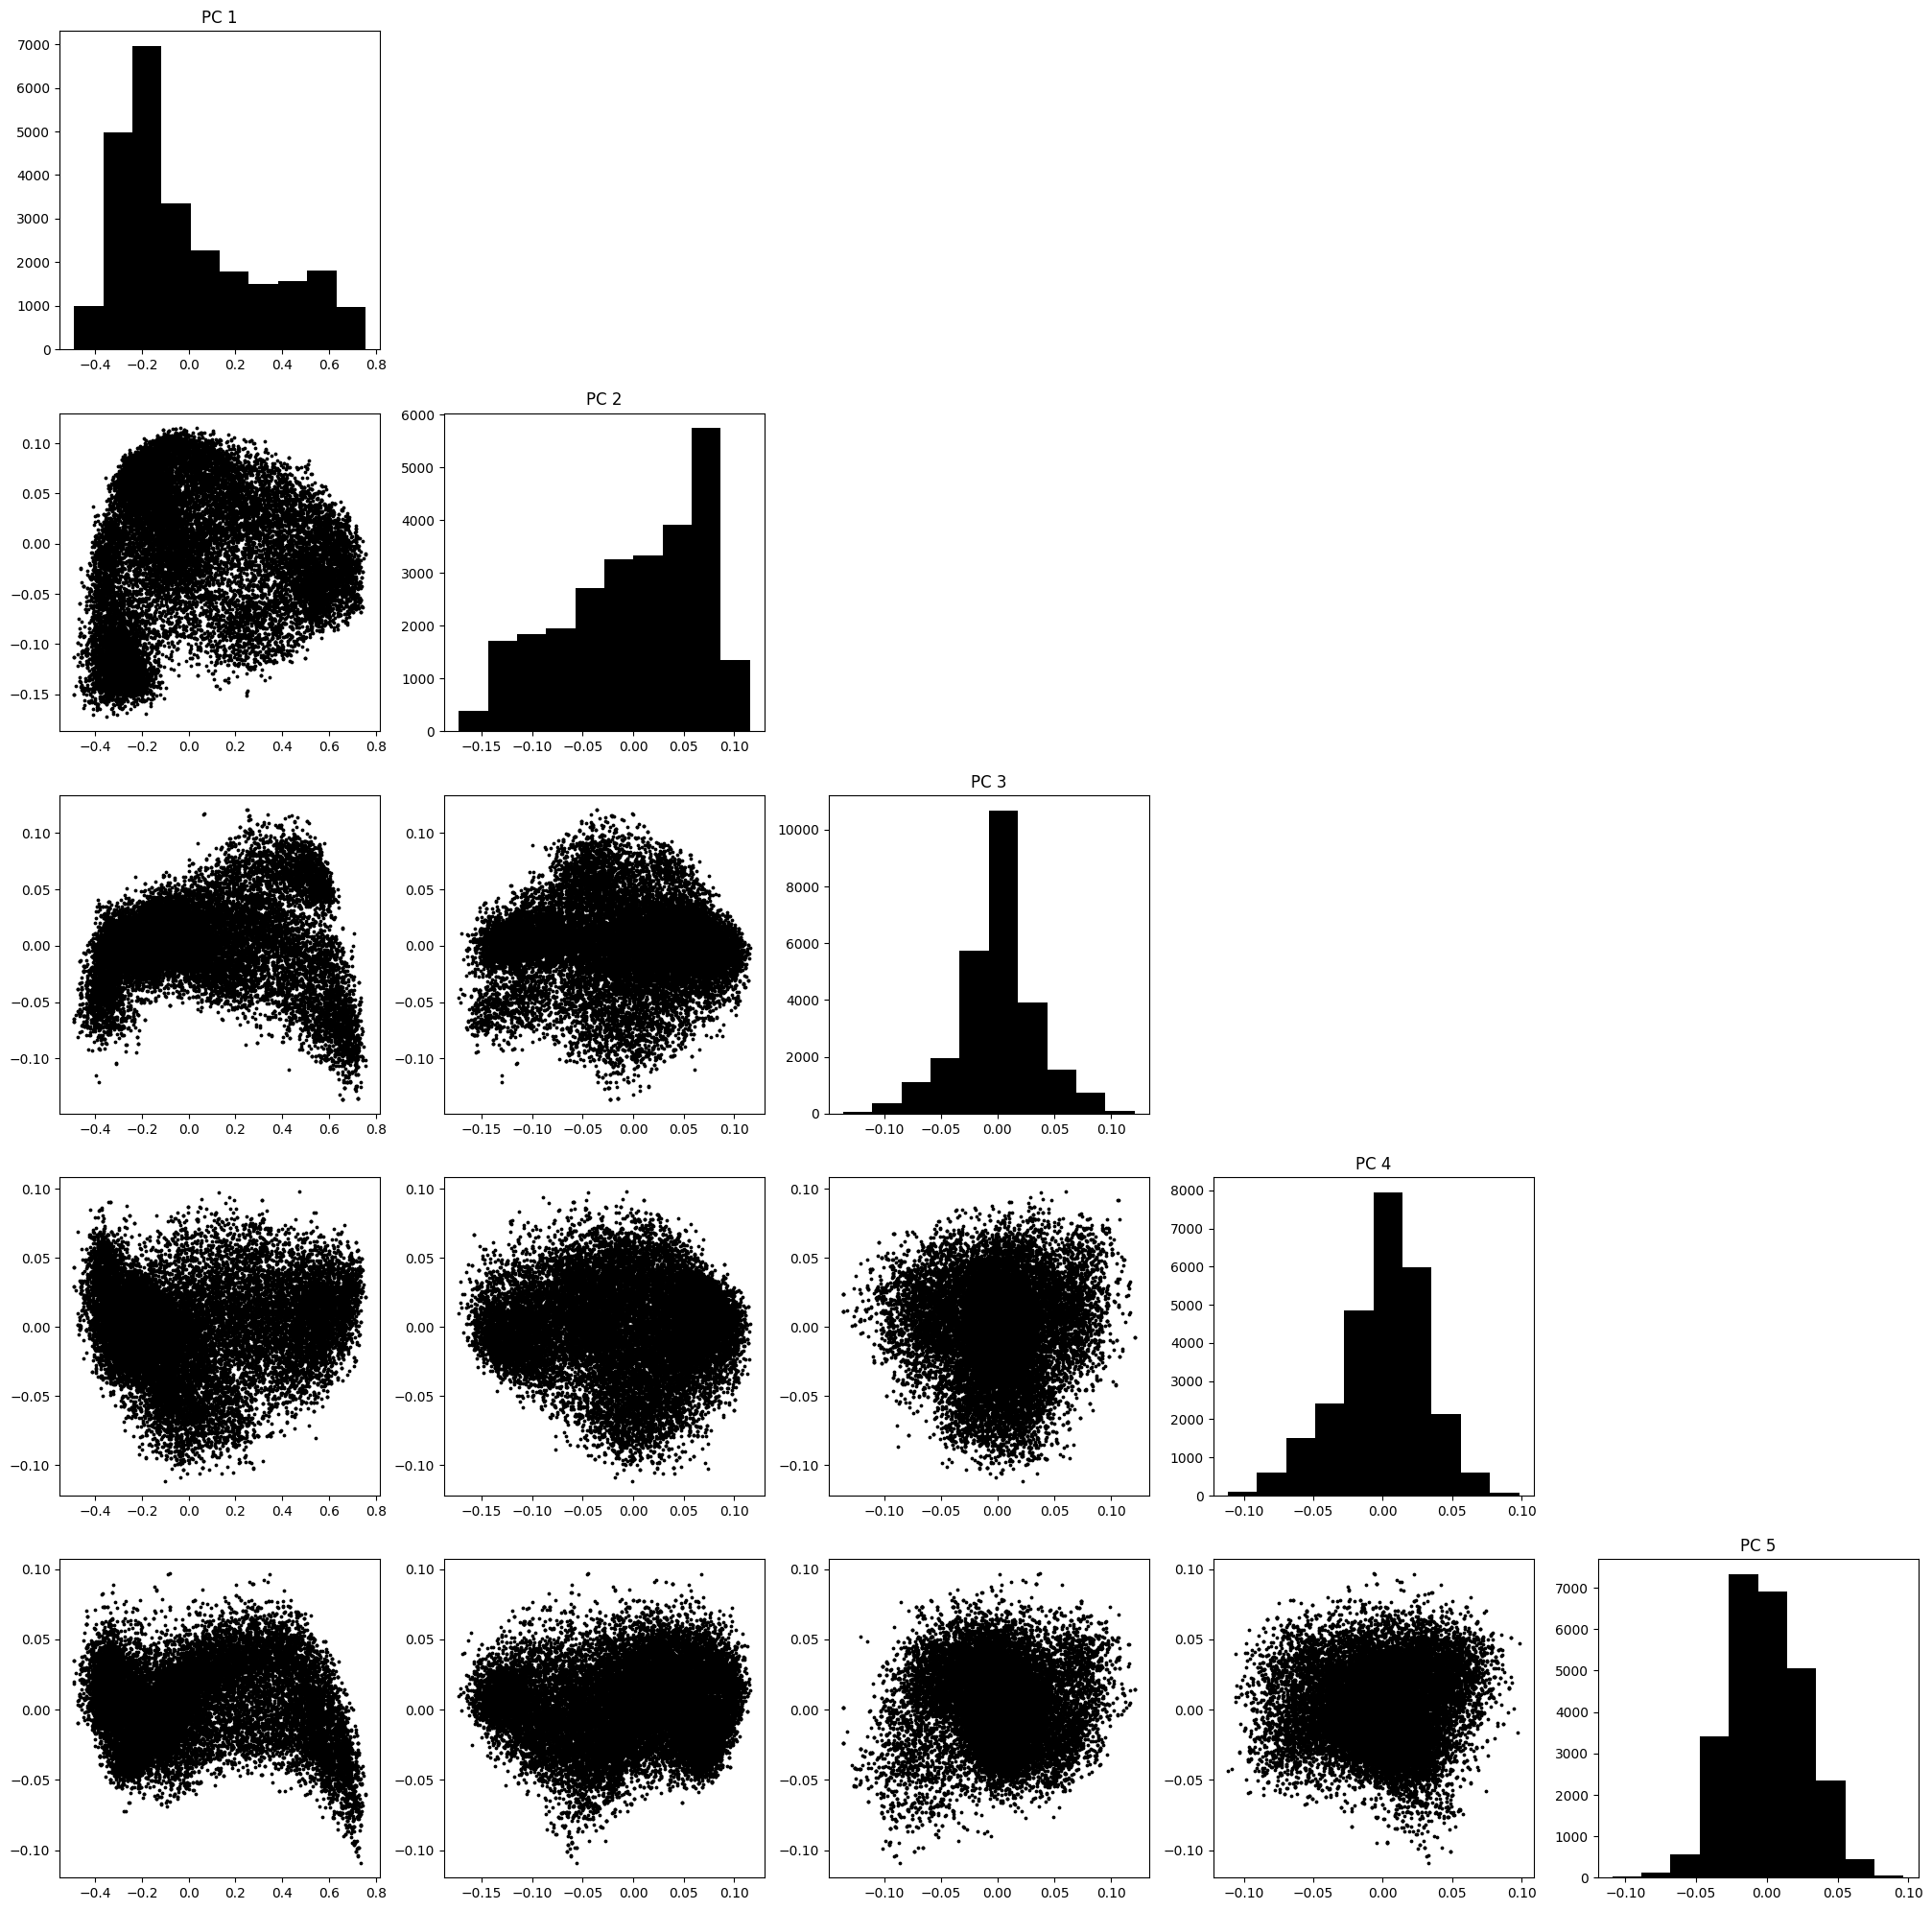

In [19]:
cell_embeddings_fpath = os.path.join(record.embeddings_dir, "cell_embedding.npz")
reasoning.load_model_precomputed_embedding(cell_embeddings_fpath)
embedding, subgraph_labels, subgraphs, vertices = reasoning.load_model_precomputed_embedding(cell_embeddings_fpath)
embedding = embedding.astype(float)

pca = PCA()
embedding_pcs = pca.fit_transform(embedding)

_num_plotted_components = 25

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(pca.explained_variance_ratio_[:_num_plotted_components], c='k')
ax.set(xlabel="PC", ylabel="log(Explained Variance Ratio)", title="PC Explained Variance Ratio", 
       xticks = list(range(0,_num_plotted_components,5)),yscale='log')
ax.set_yscale("log")
ax.grid(True)
plt.show()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.cumsum(pca.explained_variance_ratio_[:_num_plotted_components]), c='k')
ax.set(xlabel="PC", ylabel="cum(Explained Variance Ratio)", title="PC Explained Variance Ratio", 
       xticks = list(range(0,_num_plotted_components,5)))
ax.set_yticks(np.linspace(0.8, 1.0, 21))
ax.set_ylim(0.8, 1.0)
ax.grid(True)
plt.show()

fig, axes = plt.subplots(5,5,figsize=(25,25))
for i in range(5):
    axes[i,i].hist(embedding_pcs[:,i], color='k')
    axes[i,i].set_title(f'PC {i+1}')

for i in range(5):
    for j in range(i+1, 5):
        axes[i,j].set_axis_off()
        axes[j,i].scatter(embedding_pcs[:,i], embedding_pcs[:,j], c='k', s=3)

**n.b.** There appears to be an issue in UMAP's code that introduces a Numba issue (in py_nn_descent). This can be circumvented by reloading the notebook. Restart at `Cell Niche Analysis`.

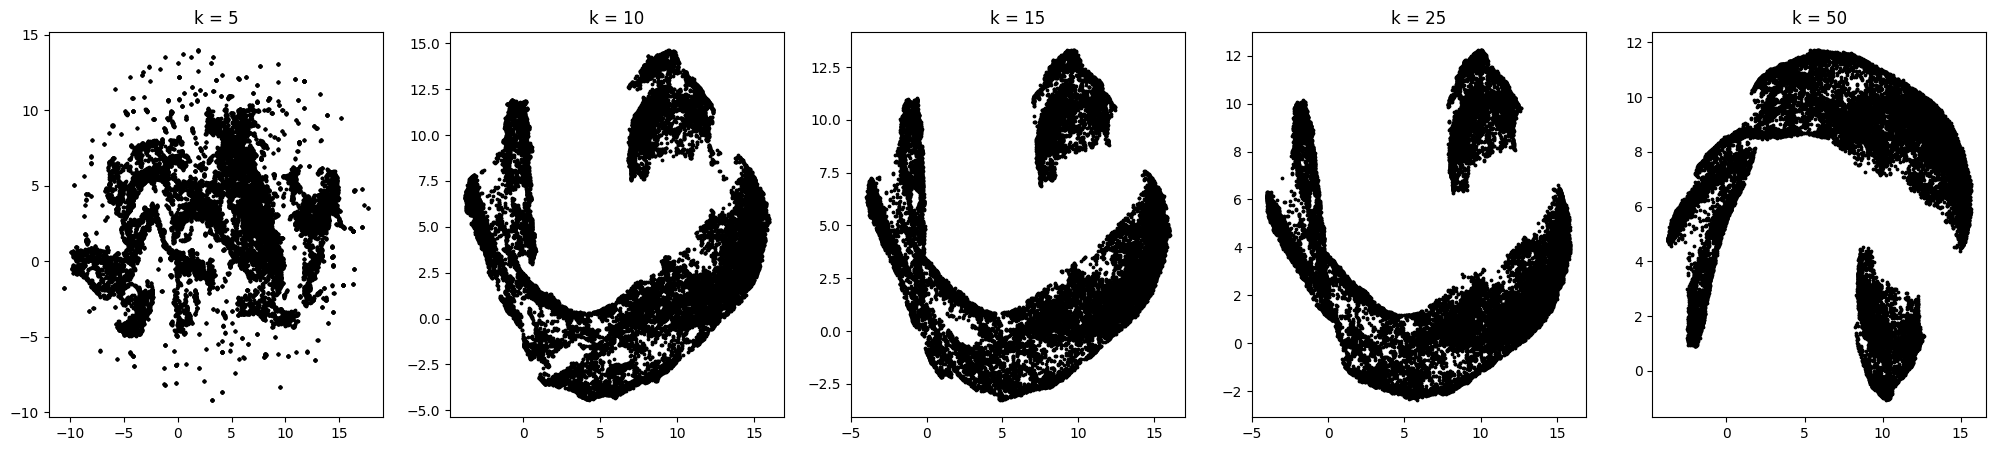

In [7]:
N_PCs_cell_niche = 10 # Number of PCs retained in pre-processing to UMAP

fig, axes = plt.subplots(1,5,figsize=(25,5))
for i, k in enumerate([5, 10, 15, 25, 50]):
    um = umap.UMAP(n_neighbors=k)
    coords = um.fit_transform(embedding_pcs[:,:N_PCs_cell_niche])
    
    axes[i].scatter(coords[:,0], coords[:,1], c='k', s=3)
    axes[i].set_title(f'k = {k}')

Text(0.5, 1.0, 'UMAP')

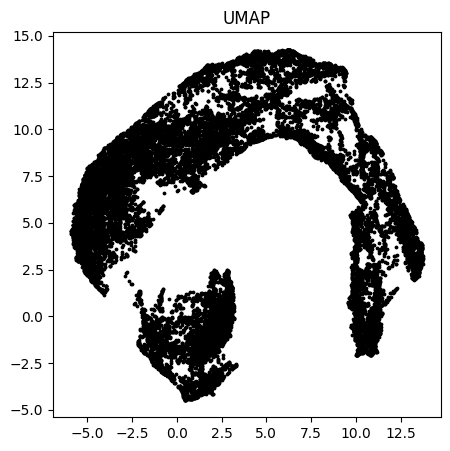

In [20]:
N_PCs_cell_niche = 10 # Number of PCs retained in pre-processing to UMAP
K_cell_niche = 10 # Chosen number of nearest neighbors

um = umap.UMAP(n_neighbors=K_cell_niche)
coords = um.fit_transform(embedding_pcs[:,:N_PCs_cell_niche])

cell_embeddings_umap_fpath = os.path.join(record.embeddings_dir, "cell_embedding_umap.npy")
np.save(cell_embeddings_umap_fpath, coords)

fig, axes = plt.subplots(figsize=(5,5))
axes.scatter(coords[:,0], coords[:,1], c='k', s=3)
axes.set_title("UMAP")

/tmp/ipykernel_135038/1316059769.py:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(coords[ma][:,0], coords[ma][:,1], c=scalarMap.to_rgba(idx), label=ni, s=1)


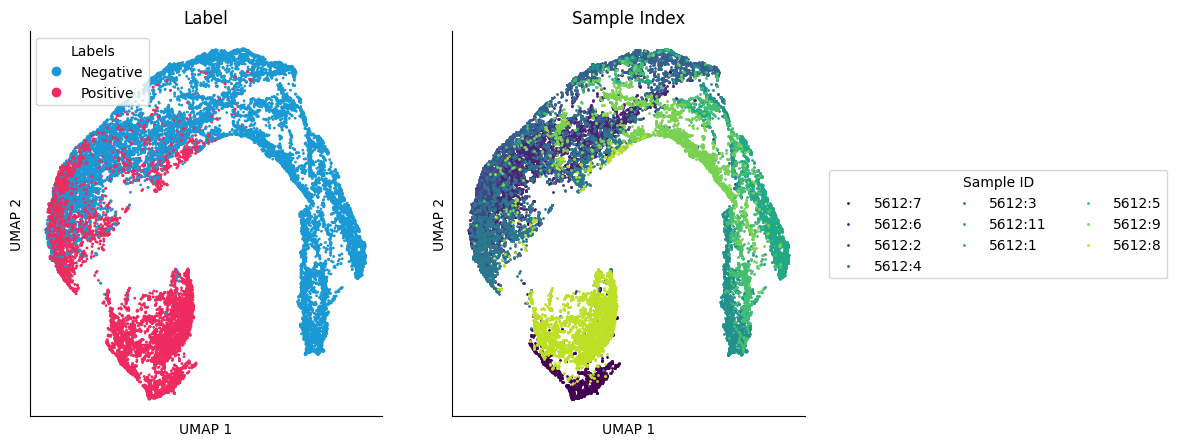

In [21]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

# Plot by label:
ax = axes[0]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('bwr_gi', ['#1A99D5','#DCDCDC','#EE2B5E'])
scatter = ax.scatter(coords[:,0], coords[:,1], c=subgraph_labels, cmap=cmap, s=1)
handles, labels = scatter.legend_elements()
ax.legend(handles, ["Negative", "Positive"], loc="upper left", title="Labels")
ax.set_title("Label")

# Plot by graph index:
subgraph_graph_remapped = [re.sub(r'\_sg_\d+$', '', s) for s in subgraphs]
reidxed = {gi:idx for idx, gi in enumerate(set(subgraph_graph_remapped))}
reidxed_inv = {idx:gi for gi, idx in reidxed.items()}
subgraph_graph_remapped_idxes = np.array([reidxed[gi] for gi in subgraph_graph_remapped])

cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=len(reidxed))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('viridis'))

ax = axes[1]
for idx in set(subgraph_graph_remapped_idxes):
    ni = reidxed_inv[idx]
    spl = ni.split("_")
    ni = f'{spl[1]}:{spl[3]}'
    ma = subgraph_graph_remapped_idxes == idx
    ax.scatter(coords[ma][:,0], coords[ma][:,1], c=scalarMap.to_rgba(idx), label=ni, s=1)
# ax.set_axis_off()
ax.legend(bbox_to_anchor=(2.05, 0.5), loc="center right", title='Sample ID', ncol=3)
ax.set_title("Sample Index")
# cbar = ax.figure.colorbar(im, ax=ax, label="Graph Index")
# cbar.ax.set_ylabel("Graph Index", rotation=-90, va="bottom")

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")

fig.savefig(os.path.join(record.plots_dir, f'cell_embedding.svg'), dpi=720, bbox_inches='tight', transparent=True)
fig.savefig(os.path.join(record.plots_dir, f'cell_embedding.png'), dpi=720, bbox_inches='tight', transparent=True)

### Subgraph Embedding:
Parallel exploration of the subgraph embedding.

In [22]:
subgraph_embeddings_fpath = os.path.join(record.embeddings_dir, "subgraph_embedding.npz")
embedding, subgraph_labels, subgraphs = reasoning.load_model_precomputed_embedding(subgraph_embeddings_fpath)

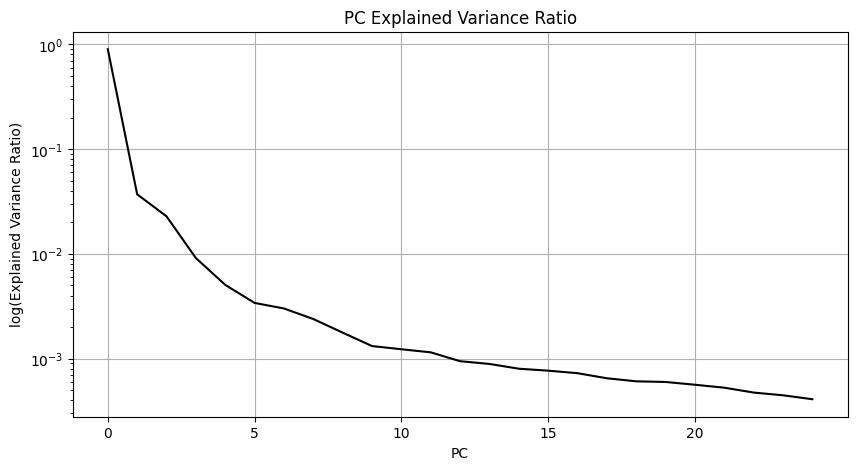

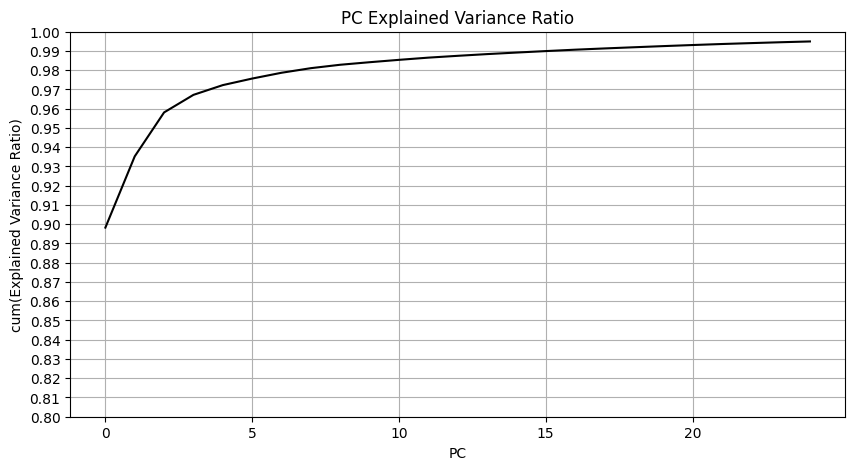

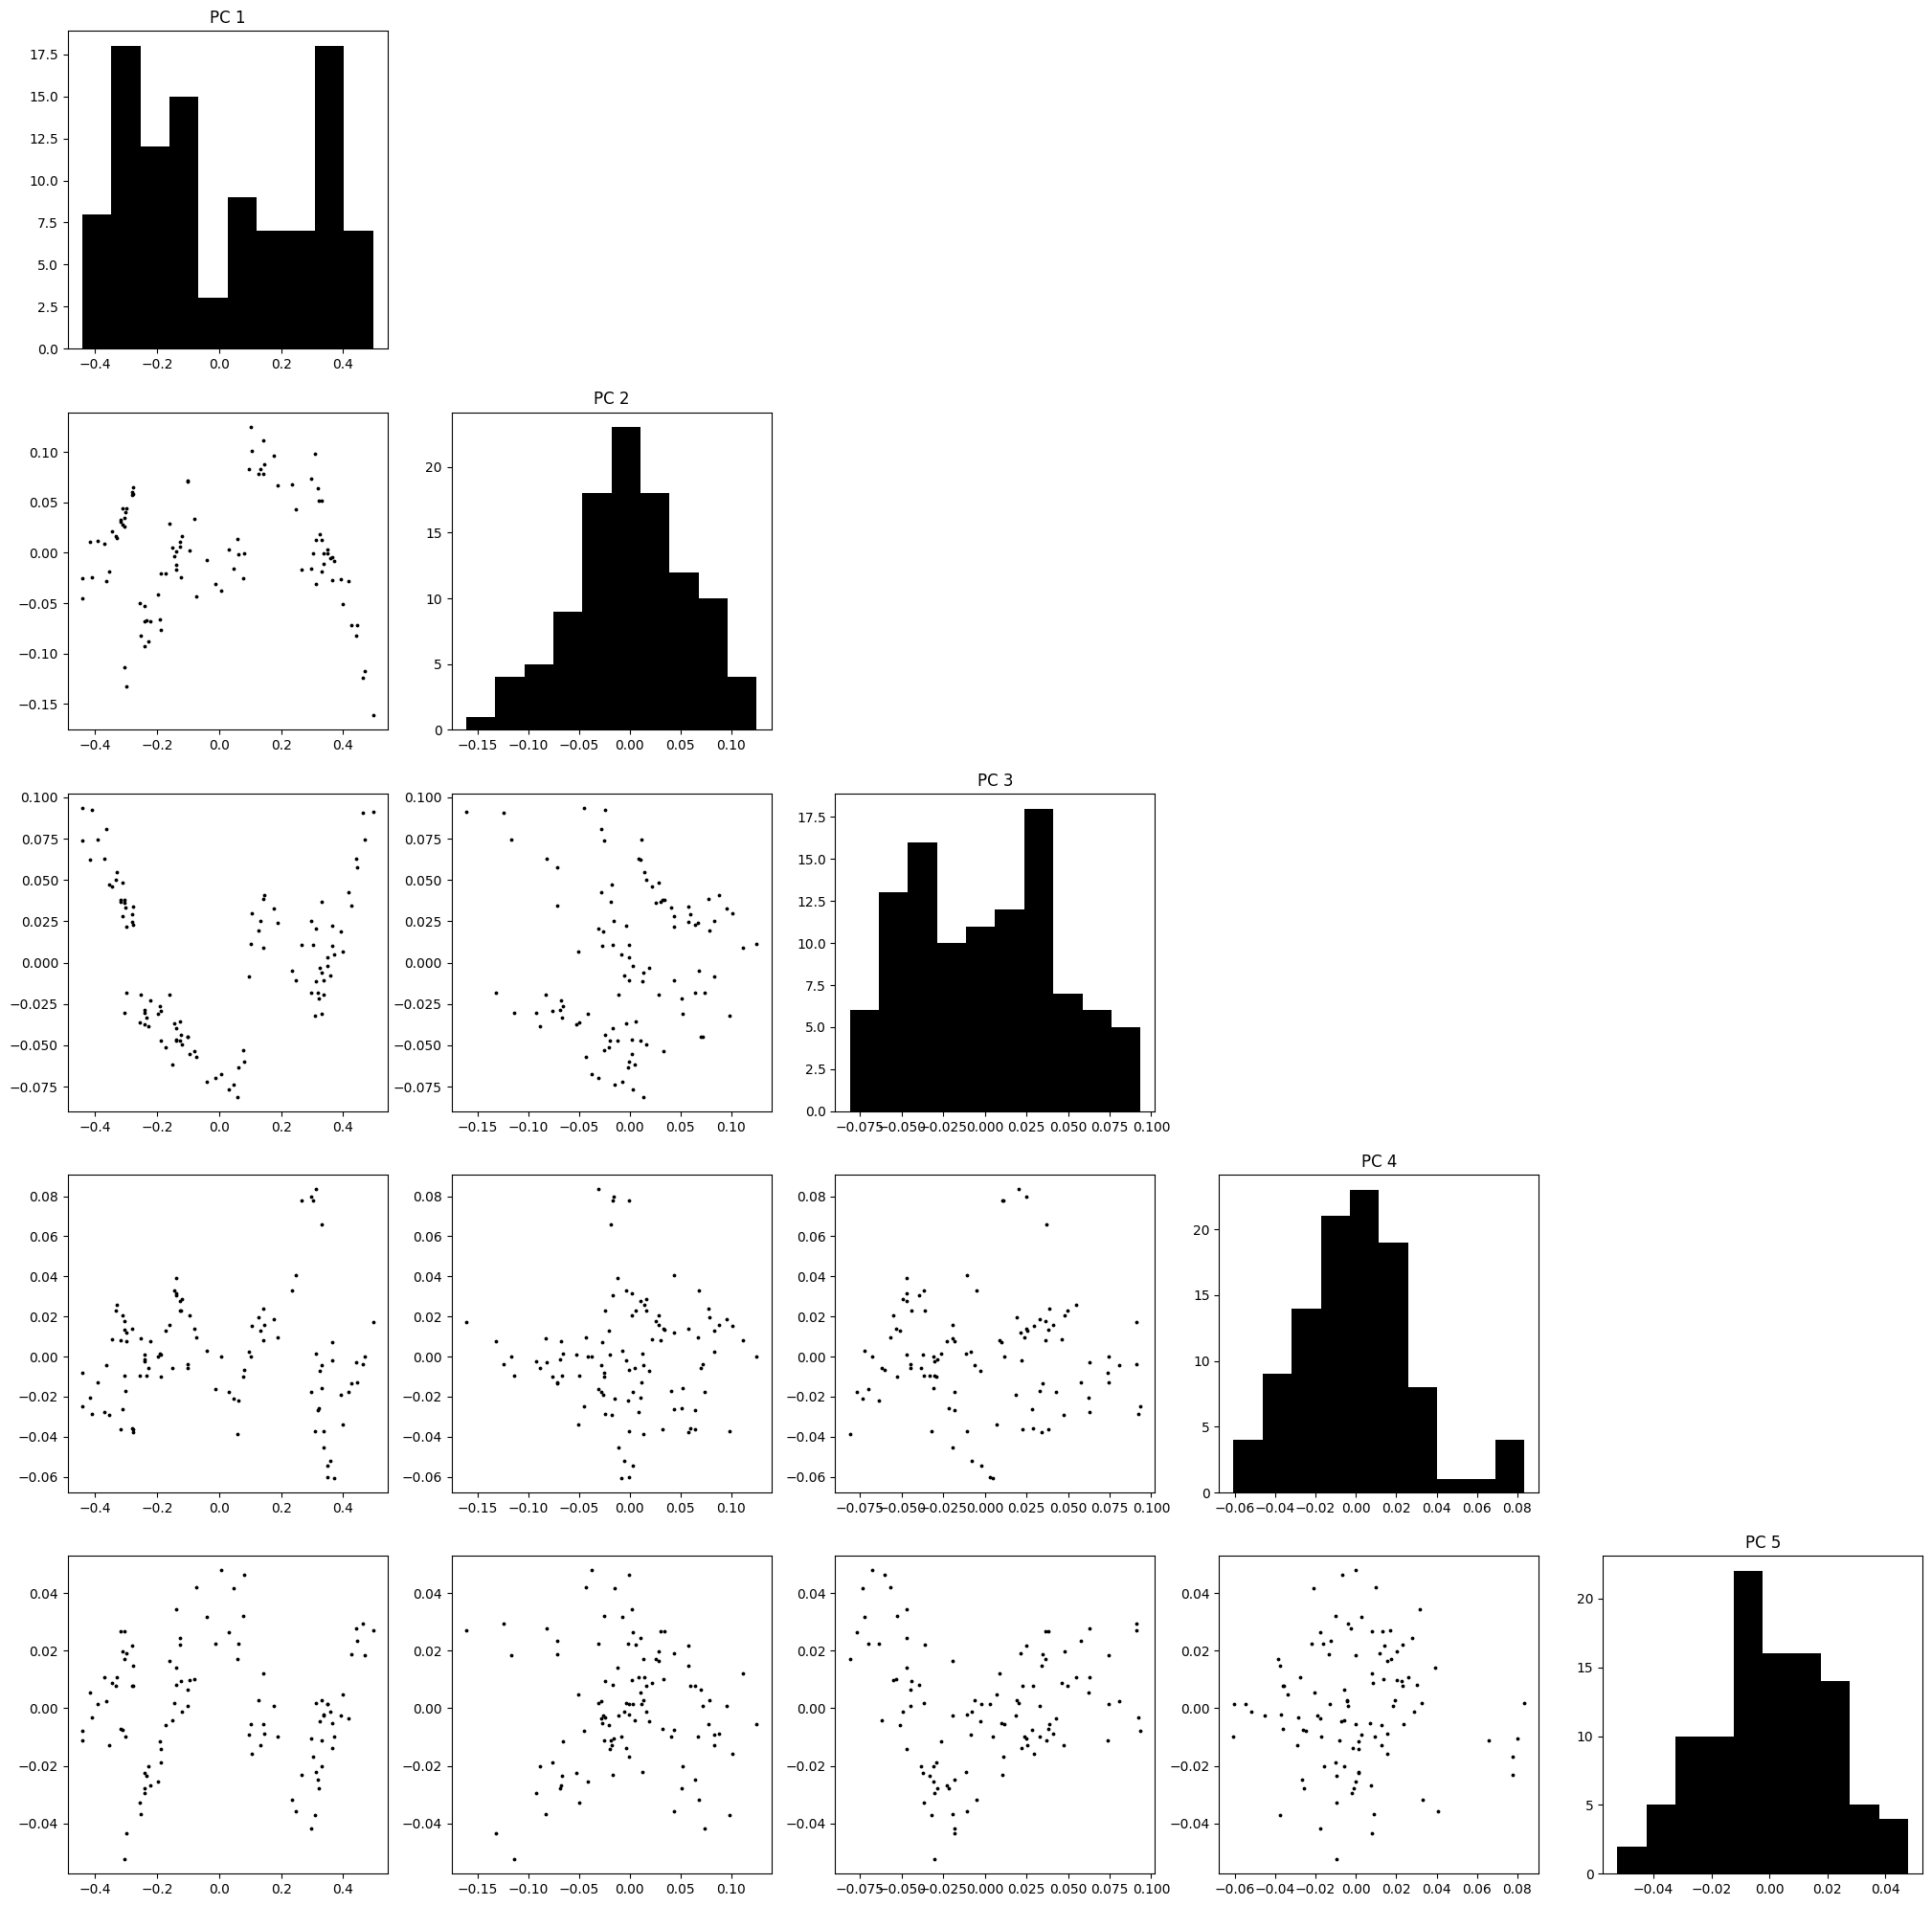

In [23]:
pca = PCA()
embedding_pcs = pca.fit_transform(embedding)


_num_plotted_components = 25

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(pca.explained_variance_ratio_[:_num_plotted_components], c='k')
ax.set(xlabel="PC", ylabel="log(Explained Variance Ratio)", title="PC Explained Variance Ratio", 
       xticks = list(range(0,_num_plotted_components,5)),yscale='log')
ax.set_yscale("log")
ax.grid(True)
plt.show()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.cumsum(pca.explained_variance_ratio_[:_num_plotted_components]), c='k')
ax.set(xlabel="PC", ylabel="cum(Explained Variance Ratio)", title="PC Explained Variance Ratio", 
       xticks = list(range(0,_num_plotted_components,5)))
ax.set_yticks(np.linspace(0.8, 1.0, 21))
ax.set_ylim(0.8, 1.0)
ax.grid(True)
plt.show()

fig, axes = plt.subplots(5,5,figsize=(25,25))
for i in range(5):
    axes[i,i].hist(embedding_pcs[:,i], color='k')
    axes[i,i].set_title(f'PC {i+1}')

for i in range(5):
    for j in range(i+1, 5):
        axes[i,j].set_axis_off()
        axes[j,i].scatter(embedding_pcs[:,i], embedding_pcs[:,j], c='k', s=3)

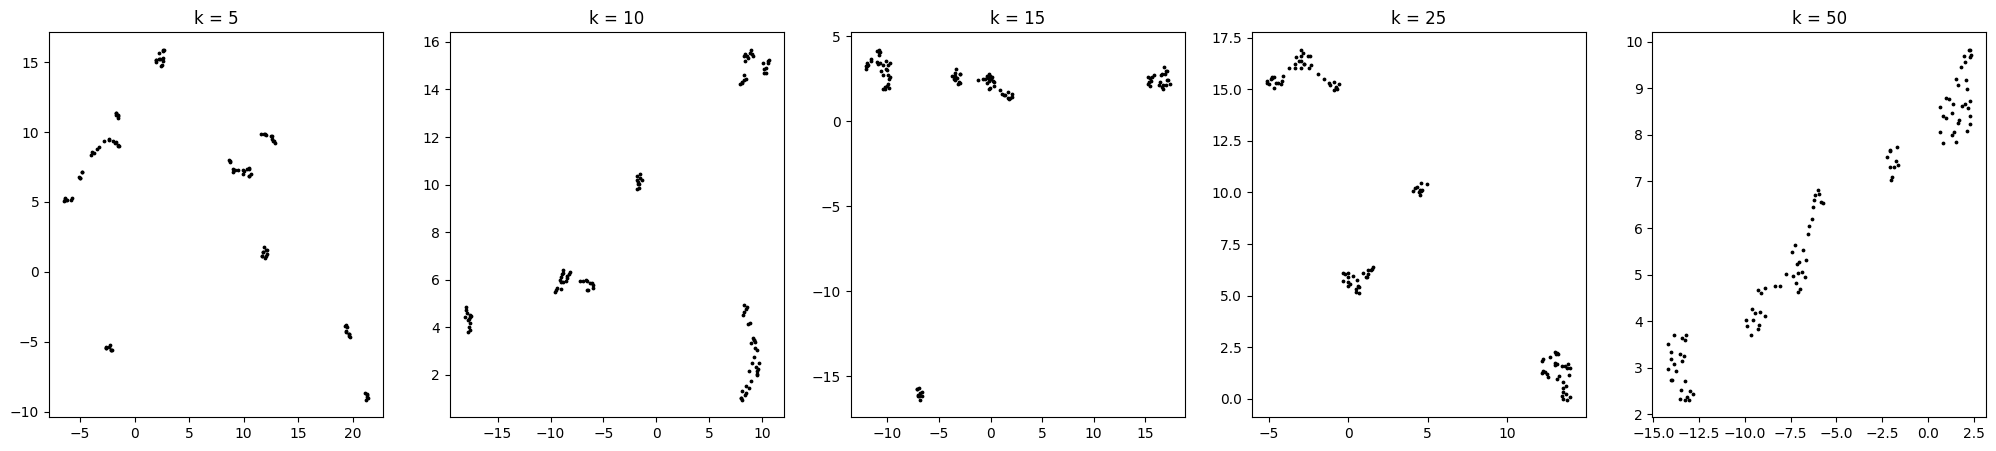

In [13]:
N_PCs_subgraph = 10 # Number of PCs retained in pre-processing to UMAP

fig, axes = plt.subplots(1,5,figsize=(25,5))
for i, k in enumerate([5, 10, 15, 25, 50]):
    um = umap.UMAP(n_neighbors=k)
    coords = um.fit_transform(embedding_pcs[:,:N_PCs_subgraph])
    
    axes[i].scatter(coords[:,0], coords[:,1], c='k', s=3)
    axes[i].set_title(f'k = {k}')

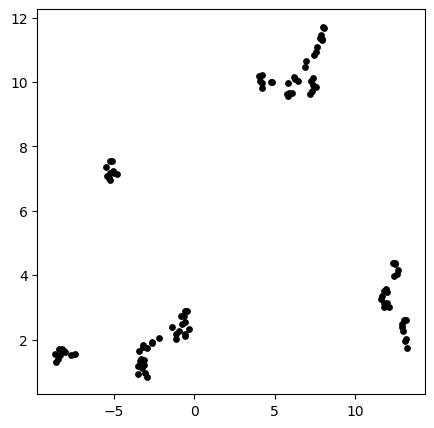

In [26]:
N_PCs_subgraph = 10
K_cell_niche = 10

um = umap.UMAP(n_neighbors=K_cell_niche)
coords = um.fit_transform(embedding_pcs[:,:N_PCs_subgraph])

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(coords[:,0], coords[:,1], c='k', s=15)
plt.show()

/tmp/ipykernel_135038/911070108.py:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(coords[ma][:,0], coords[ma][:,1], c=scalarMap.to_rgba(idx), label=ni, s=10)


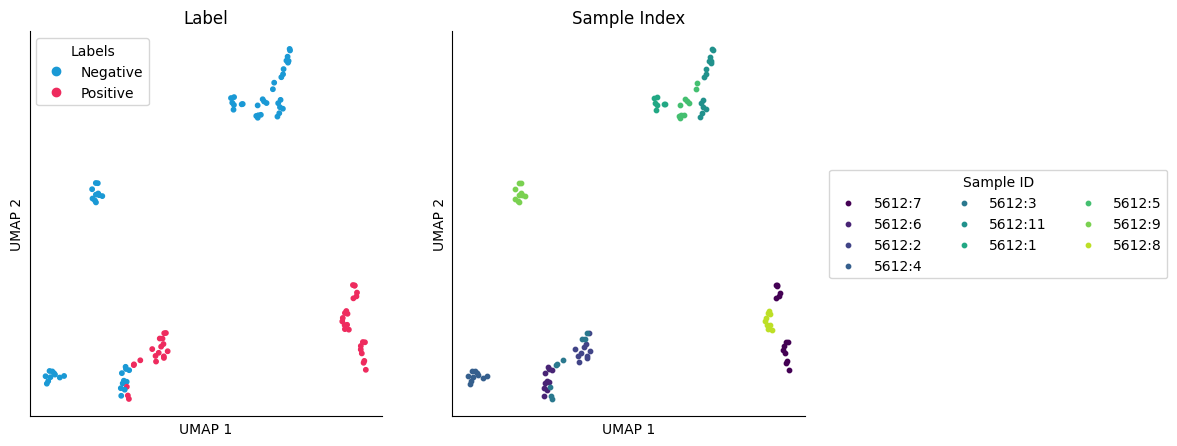

In [27]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

# Plot by label:
ax = axes[0]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('bwr_gi', ['#1A99D5','#DCDCDC','#EE2B5E'])
scatter = ax.scatter(coords[:,0], coords[:,1], c=subgraph_labels, cmap=cmap, s=10)
handles, labels = scatter.legend_elements()
ax.legend(handles, ["Negative", "Positive"], loc="best", title="Labels")
ax.set_title("Label")

# Plot by graph index:
subgraph_graph_remapped = [re.sub(r'\_sg_\d+$', '', s) for s in subgraphs]
reidxed = {gi:idx for idx, gi in enumerate(set(subgraph_graph_remapped))}
reidxed_inv = {idx:gi for gi, idx in reidxed.items()}
subgraph_graph_remapped_idxes = np.array([reidxed[gi] for gi in subgraph_graph_remapped])

cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=len(reidxed))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('viridis'))

ax = axes[1]
for idx in set(subgraph_graph_remapped_idxes):
    ni = reidxed_inv[idx]
    spl = ni.split("_")
    ni = f'{spl[1]}:{spl[3]}'
    ma = subgraph_graph_remapped_idxes == idx
    ax.scatter(coords[ma][:,0], coords[ma][:,1], c=scalarMap.to_rgba(idx), label=ni, s=10)
# ax.set_axis_off()
ax.legend(bbox_to_anchor=(2.05, 0.5), loc="center right", title='Sample ID', ncol=3)
ax.set_title("Sample Index")
# cbar = ax.figure.colorbar(im, ax=ax, label="Graph Index")
# cbar.ax.set_ylabel("Graph Index", rotation=-90, va="bottom")

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")

fig.savefig(os.path.join(record.plots_dir, f'subgraph_embedding.svg'), dpi=720, bbox_inches='tight', transparent=True)
fig.savefig(os.path.join(record.plots_dir, f'subgraph_embedding.png'), dpi=720, bbox_inches='tight', transparent=True)

## Cell Significance:
Finally, we can compute the cell niche significance scores arising the cell niche and subgraph embeddings. This computation uses the function `reasoning.cell_niche_significance_idw` to compute the weighted embeddings. The docstring for this function is:
```Python
def cell_niche_significance_idw(cell_embedding: np.ndarray, subgraph_embedding: np.ndarray, subgraph_labels: np.ndarray,
        p: Tuple[int, List[int]] = 2, distance: str = "geodesic", k: Optional[int] = 25) -> Dict[int, np.ndarray]:
    """Estimates the cell-niche significance using an inverse-distance weighting scheme over 1 or multiple scaling parameters p

    Args:
        cell_embedding: an (n x d) array representing the d-dimensional embedding of n cells. 
        subgraph_embedding: an (m x d) array representing the d-dimensional embedding of m subgraphs 
        subgraph_labels: a length m array encoding the labels (values: {0,1}) for each of the m subgraphs.
        p: chosen values for the re-scaling factors p. Passed as single integer or list of integers. 
        distance: the distance option used for computing distances between cell_embedding and subgraph_embedding.
            Options include the geodesic, euclidean and manhattan distances.
        k: an optional value for defining a k-nearest neighbors graph. Used with the 'geodesic' option for distance 
        
    Returns:
        A dictionary mapping from chosen p values to the associated embeddings.
    """
```
(See `SORBET/reasoning/cell_niche_significance.py:18-33`)

We first extract the appropriate niche and subgraph embeddings, then compute the scores for cell niches, and (finally) plot these scores on the original data.

In [28]:
cell_significance_plots_dir = os.path.join(record.plots_dir, 'cell_significance')
if not os.path.exists(cell_significance_plots_dir): os.makedirs(cell_significance_plots_dir)

In [29]:
cell_embeddings_fpath = os.path.join(record.embeddings_dir, "cell_embedding.npz")
reasoning.load_model_precomputed_embedding(cell_embeddings_fpath)
cell_embedding, cell_labels, cell_subgraphs_keys, cell_indices = reasoning.load_model_precomputed_embedding(cell_embeddings_fpath)
cell_embedding = cell_embedding.astype(float)

subgraph_embeddings_fpath = os.path.join(record.embeddings_dir, "subgraph_embedding.npz")
subgraph_embedding, subgraph_labels, subgraph = reasoning.load_model_precomputed_embedding(subgraph_embeddings_fpath)
subgraph_embedding = subgraph_embedding.astype(float)

n_pcs = 10 # N. PCs chosen as in Embedding:Cell
pca = PCA()
cell_embedding_pcs = pca.fit_transform(cell_embedding)[:,:n_pcs]
subgraph_embedding_pcs = pca.transform(subgraph_embedding)[:,:n_pcs]

In [30]:
scores = reasoning.cell_niche_significance_idw(cell_embedding_pcs, subgraph_embedding_pcs, subgraph_labels, distance='euclidean', p=[0.5,1,2,3,4,5,10], k=10)

Computing euclidean
Computed Euclidean


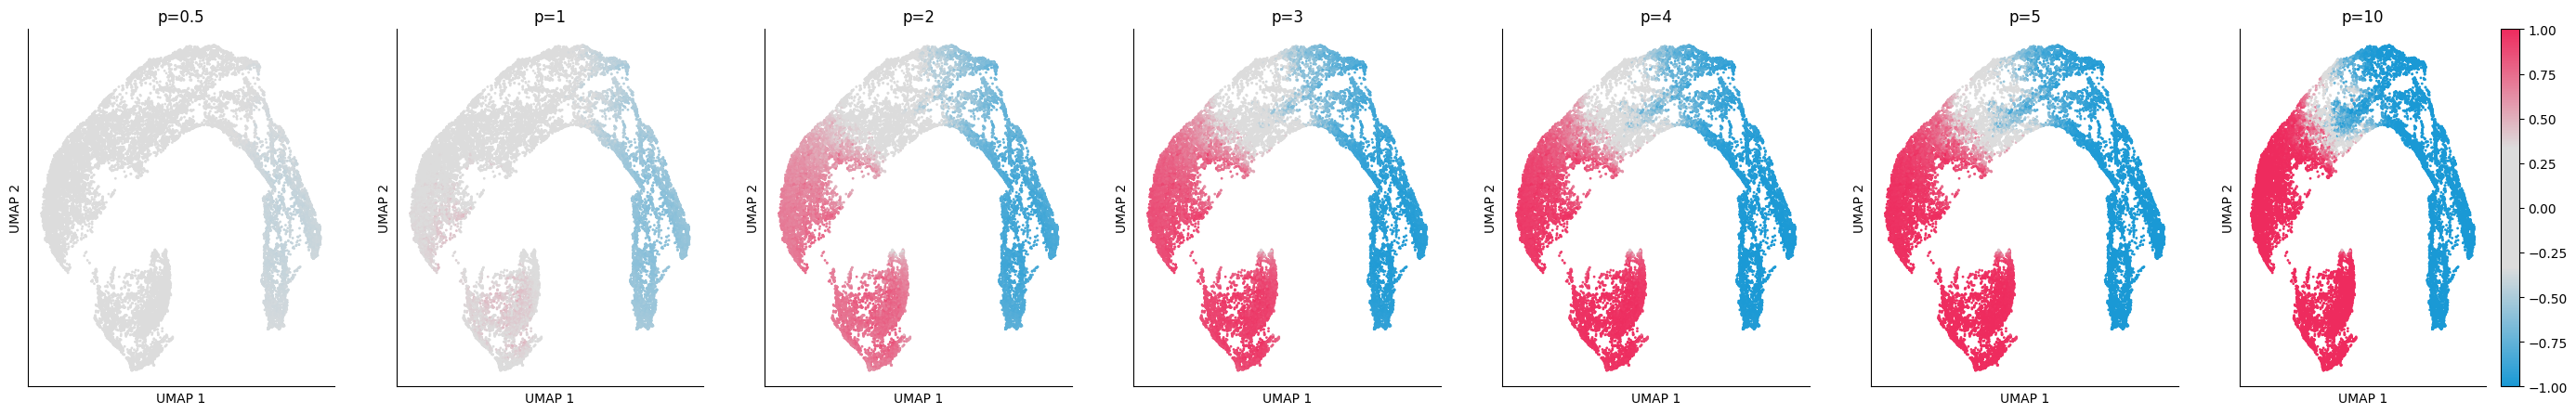

In [31]:
cell_embeddings_umap_fpath = os.path.join(record.embeddings_dir, "cell_embedding_umap.npy")
umap_coords = np.load(cell_embeddings_umap_fpath)

fig, axes = plt.subplots(1,len(scores),figsize=(5 * len(scores),5))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('bwr_gi', ['#1A99D5','#DCDCDC', '#DCDCDC','#EE2B5E'])
for i, (p,_scores) in enumerate(sorted(scores.items(), key=lambda t: t[0])):
    ax=axes[i]
    scatter = ax.scatter(umap_coords[:,0], umap_coords[:,1], c=_scores, cmap=cmap, s=1, norm=matplotlib.colors.Normalize(vmin=-1, vmax=1))
    if i == (len(scores)-1):
        cbar = fig.colorbar(scatter)
    ax.set_title(f'p={p}')
    
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    ax.set_xticks([])
    ax.set_yticks([])

ofname = os.path.join(cell_significance_plots_dir, 'significance_umap_range')
# fig.savefig(f'{ofname}.svg', bbox_inches='tight', transparent=True, dpi=720)
# fig.savefig(f'{ofname}.png', bbox_inches='tight', transparent=True, dpi=720)

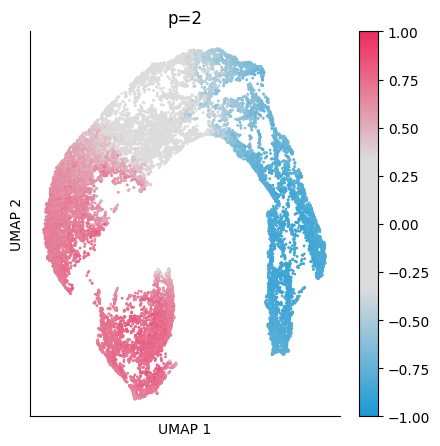

In [34]:
p = 2
chosen_scores = scores[p] # Chosen for p = 3
fig, axes = plt.subplots(figsize=(5,5))
scatter = axes.scatter(umap_coords[:,0], umap_coords[:,1], c=chosen_scores, cmap=cmap, s=1, norm=matplotlib.colors.Normalize(vmin=-1, vmax=1))
cbar = fig.colorbar(scatter)
axes.set_title(f'p={p}')

axes.spines[['right', 'top']].set_visible(False)
axes.set_xlabel("UMAP 1")
axes.set_ylabel("UMAP 2")
axes.set_xticks([])
axes.set_yticks([])

ofname = os.path.join(cell_significance_plots_dir, 'significance_umap_chosen')
fig.savefig(f'{ofname}.svg', bbox_inches='tight', transparent=True, dpi=720)
fig.savefig(f'{ofname}.png', bbox_inches='tight', transparent=True, dpi=720)

### Subgraph Score Plotting:

Use the cell niche scores to color each individual 

**Note:** `plot_cell_niche_scores` below will need adaptation to each dataset. For the CosMx data, we have the polygons assigned to each cell and the code corresponds to that choice. Alternatively, one might scatter points per xy-coordinates and plot colors.

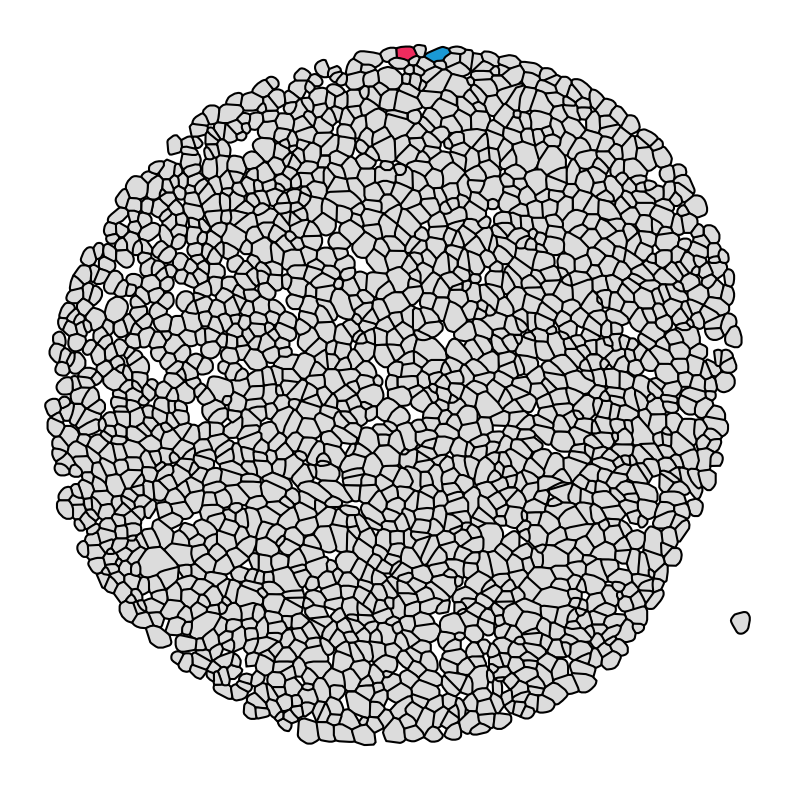

In [44]:
polygon_file = "data/tutorial/input_data/polygons.csv"
cmap_bwr_upd = matplotlib.colors.LinearSegmentedColormap.from_list('bwr_gi', ['#1A99D5','#DCDCDC', '#DCDCDC','#EE2B5E'])

def plot_polygon(graph_id: str,
                 cell_ids: set = None, labeled_cells: dict = dict(), polygon_file: str = polygon_file,
                 cmap = cmap_bwr_upd, norm: matplotlib.colors.Normalize = matplotlib.colors.TwoSlopeNorm(vmin=-1.0, vmax=1.0, vcenter=0.0), 
                 ax: plt.axis = None, edge_args: dict = {'edgecolor': 'k', 'linewidth': 1.5}, add_colorbar=False):
    """Plots a graph with scored cells according to an input polygon file.

    Args:
        graph_id: ID of graph. Format run_[Run ID]_fov_[FOV ID]
        cell_ids: optional argument to provide a set of cell IDs to focus on. If none
        labeled_cells: dictionary mapping cell IDs to a score 
        polygon_file: filepath to the bounding polygons on each cell
        cmap: chosen colormap (matplotlib)
        norm: normalization function (matplotlib)
        ax: matplotlib axis, if necessary
        edge_args: arguments to define the line stile for the bounding polygon for each cell

    Returns:
        Optionally returns a figure if no axis is passed to the ax argument.
    """
    
    # Create a function to match cell IDs in polygons to selected cell IDs. 
    if cell_ids is None:
        cell_ids = set(pickle.load(open(f"data/tutorial/graphs_py/complete/{graph_id}.p",'rb'))[0][1])
    
    check_cell_id = lambda k: k in cell_ids or k in labeled_cells
    

    # Extract bounding polygons from the input file for the chosen graph.
    reader = csv.reader(open(polygon_file, 'r'))
    next(reader, None)

    fov = int(graph_id.split("_")[-1])
    
    per_cell = defaultdict(list)
    for fid, cid, x, y, _, _ in reader:
        fid, cid = int(fid), int(cid)
        if fov == fid and check_cell_id(cid):
            per_cell[cid].append((float(x), float(y)))

    # Return the figure if we need to create it. Otherwise, continue.
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))
        return_fig = True
    else:
        return_fig = False

    # Select coloring function. The resulting function `get_color` takes a single value and maps to 
    if len(labeled_cells) == 0:
        def get_color(qi):
            return '#DCDCDC'
    elif norm is not None:
        cmapper = matplotlib.colormaps[cmap] if isinstance(cmap, str) else cmap
        def get_color(qi, norm=norm, cmapper=cmapper):
            return matplotlib.colors.to_hex(cmapper(norm(qi)))
    else:
        get_color = lambda si: si

    default_value = "#DCDCDC" if (norm is None and len(labeled_cells) > 0) else norm.vcenter
    
    for cid, tups in per_cell.items():
        xs, ys = zip(*tups)
        si = labeled_cells.get(cid, default_value)
        ax.fill(list(xs), list(ys), get_color(si), **edge_args)

    if norm is not None and add_colorbar:
        sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
        plt.colorbar(sm, ax=ax)
    ax.set_axis_off()
    if return_fig: return fig

# A minimal example of plotting a function:
# We assign scores to two cells to demonstrate how the default background contrasts with scored cells.
plot_polygon("run_5612_fov_1", labeled_cells={1:1.0,2:-1.0});

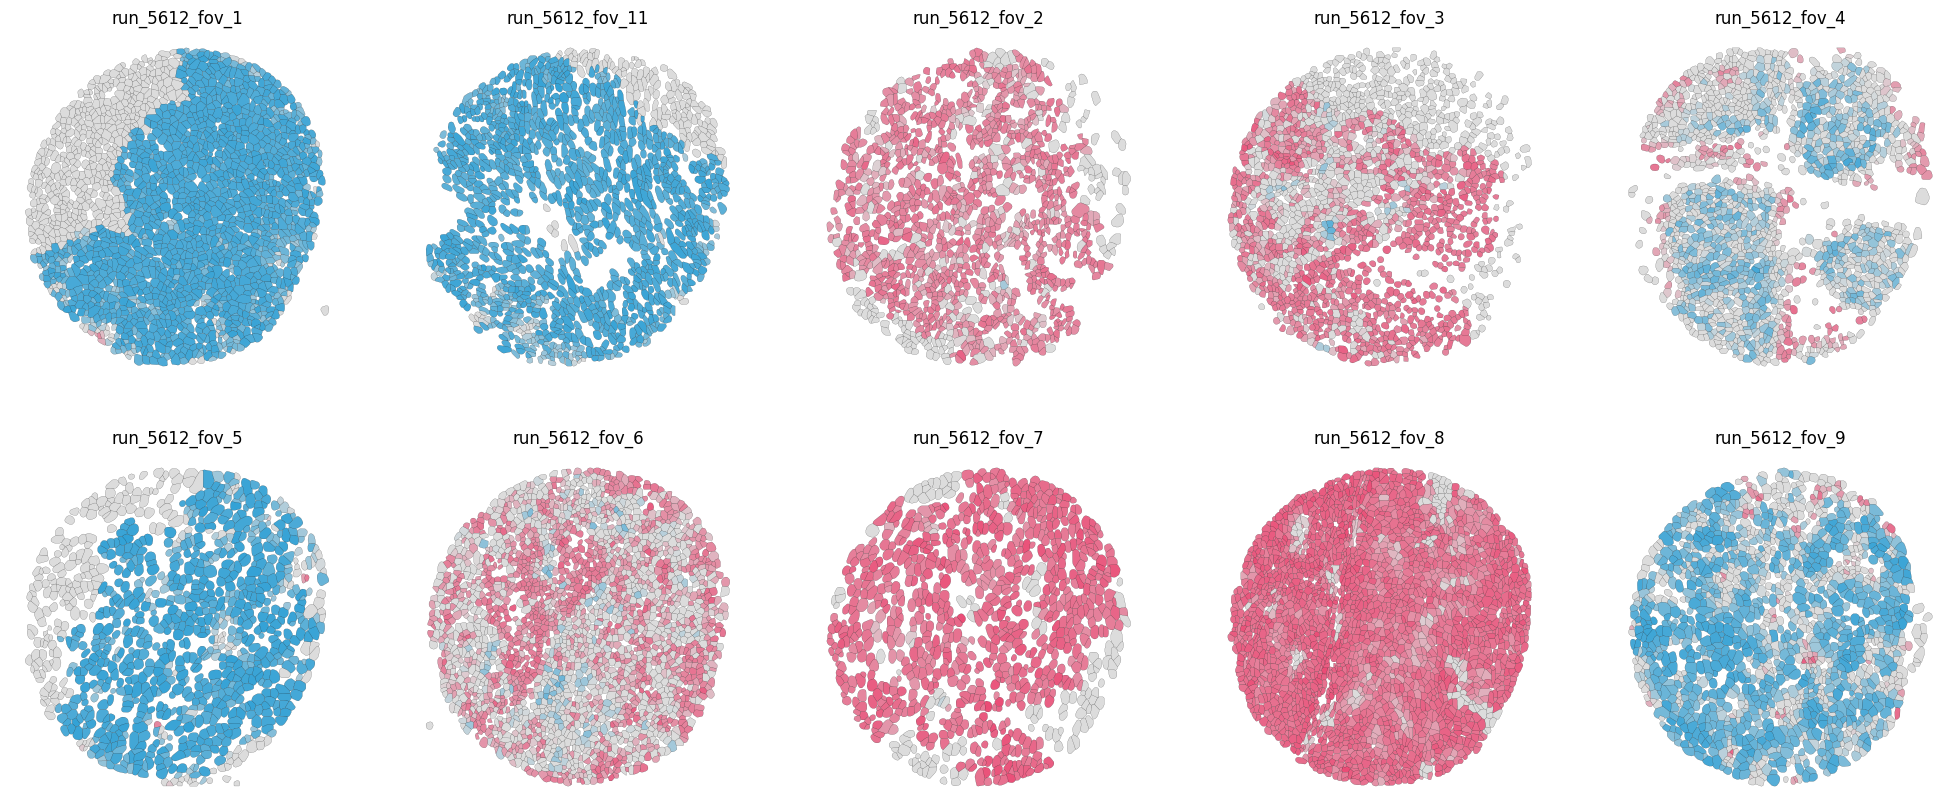

In [63]:
# Now, plot all of the subgraphs using the inferred scores:
cell_graph_keys = np.array([sgi.split("_sg")[0] for sgi in cell_subgraphs_keys])


fig, axes = plt.subplots(2,5,figsize=(25,10))
subplot_edge_style = {'edgecolor': 'k', 'linewidth': 0.1}

_subgraph_ids = sorted(set(cell_graph_keys))
for idx, sgi in enumerate(_subgraph_ids):
    # Extract scores for each cell:
    mask = cell_graph_keys == sgi
    paired_iterator = zip(cell_indices[mask], scores[2][mask])
    scored_cells = {cell_idx:score for cell_idx, score in paired_iterator}

    # Plot the resulting values:
    ridx, cidx = idx // 5, idx % 5
    plot_polygon(sgi, labeled_cells = scored_cells, ax = axes[ridx, cidx], edge_args = subplot_edge_style) 
    axes[ridx, cidx].set_title(sgi)
    
plt.show()

# Marker Analysis:
In the marker analysis, we will explore the spatially informed marker analysis, which will lead to the sparse CCA analysis.

In [64]:
cell_embeddings_fpath = os.path.join(record.embeddings_dir, "cell_embedding.npz")
reasoning.load_model_precomputed_embedding(cell_embeddings_fpath)
cell_embedding, cell_labels, cell_subgraphs_keys, cell_indices = reasoning.load_model_precomputed_embedding(cell_embeddings_fpath)
cell_embedding = cell_embedding.astype(float)

subgraph_embeddings_fpath = os.path.join(record.embeddings_dir, "subgraph_embedding.npz")
subgraph_embedding, subgraph_labels, subgraph = reasoning.load_model_precomputed_embedding(subgraph_embeddings_fpath)
subgraph_embedding = subgraph_embedding.astype(float)

n_pcs = 10 # N. PCs chosen as in Embedding:Cell
pca = PCA()
cell_embedding_pcs = pca.fit_transform(cell_embedding)[:,:n_pcs]
subgraph_embedding_pcs = pca.transform(subgraph_embedding)[:,:n_pcs]

In [65]:
graph_phenotype_labels = dict()
for gi, sgi in zip(subgraph_labels, subgraph):
    graph_phenotype_labels[sgi.split("_sg_")[0]] = gi

In [66]:
metadata_files = learning.make_subgraph_metadata("data/tutorial/processed_subgraphs/znormalized/")

subgraph_order = list()
for si in cell_subgraphs_keys:
    if si not in subgraph_order: subgraph_order.append(si)

cell_raw_data = list()
for sgi in subgraph_order:
    sg = data_handling.load_omicsgraph(os.path.join(metadata_files.processed_dirpath, "graphs_py", f'{sgi}.p'))

    cell_raw_data.append(sg.get_node_data())
cell_raw_data = np.vstack(cell_raw_data)

### Cross Validation:
First, we use the `reasoning.sparse_cca_kfold_cv` function. Herre, we will compare the profile of each cell with its eventual cell niche embedding. 

The way to identify the appropriate regularization is via the `lambdaxs` and `lambdays` arguments. The function completes a grid search over these parameter spaces. 

Note, here, we will always set `lambdays = [0]`. This means that the cell embedding is not regularized.

 12%|████████████████████████▊                                                                                                                                                                             | 1/8 [01:11<08:17, 71.03s/it]

(1e-08, 0) 0.9246955019334426 1045.0


 25%|█████████████████████████████████████████████████▌                                                                                                                                                    | 2/8 [02:10<06:26, 64.48s/it]

(1e-06, 0) 0.9429723944673332 1045.0


 38%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 3/8 [03:05<04:58, 59.78s/it]

(0.0001, 0) 0.9038882694066809 1045.0


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 4/8 [04:00<03:52, 58.20s/it]

(0.01, 0) 0.9359157651164405 1038.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 5/8 [04:55<02:50, 56.96s/it]

(1, 0) 0.9213384602707249 316.5


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 6/8 [05:18<01:30, 45.34s/it]

The following regularization parameters result in invalid results: 100 (input), 0 (embedding). Excluding.


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 7/8 [05:38<00:36, 36.94s/it]

The following regularization parameters result in invalid results: 10000 (input), 0 (embedding). Excluding.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [06:00<00:00, 45.09s/it]

The following regularization parameters result in invalid results: 1000000 (input), 0 (embedding). Excluding.


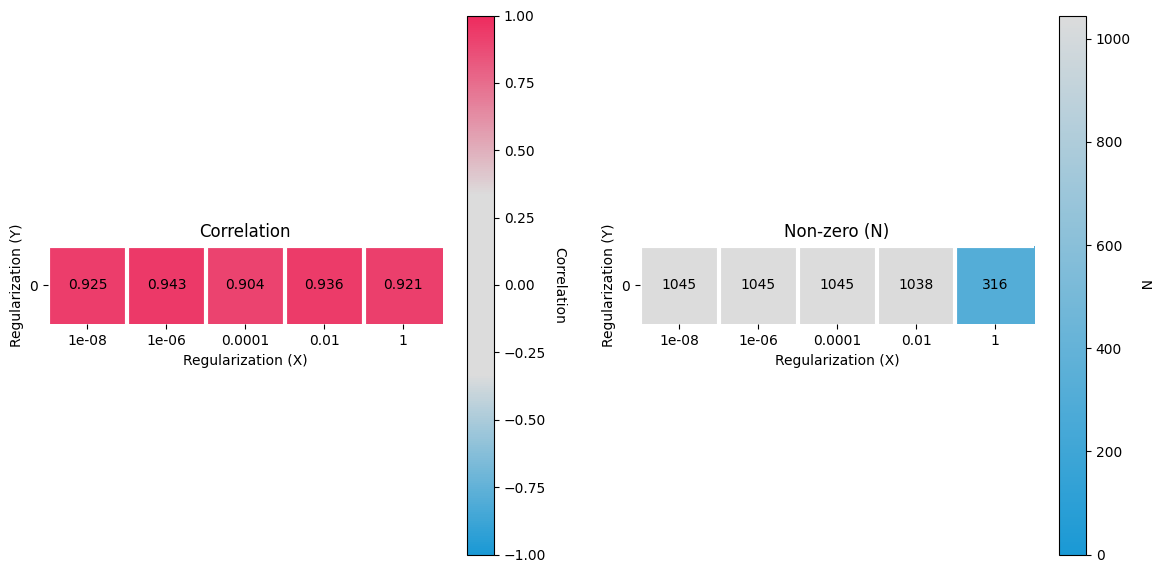

In [67]:
# Fit k-Fold CV to data. Broadly sweep through regularization values to find a good range.
in_data = cell_raw_data
out_data = cell_embedding

dev=torch.device("cuda:7")
best_regularizer, correlations, norms = reasoning.sparse_cca_kfold_cv(in_data, out_data, 
                                                                      lambdaxs = [10**i for i in range(-8, 8, 2)], lambdays = [0],
                                                                      dev = dev)

reasoning.plot_kfold_regularization(correlations, norms);

Regularization values > 1 appear to result in invalid CCA runs. Between 0.01 and 1, there appears to be a rapid decrease in the number of components, while correlation is retained. We will further explore this range:

 33%|██████████████████████████████████████████████████████████████████                                                                                                                                    | 1/3 [00:52<01:45, 52.85s/it]

(0.01, 0) 0.9338009869849977 1034.5


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 2/3 [01:47<00:53, 53.83s/it]

(0.1, 0) 0.9426386561516339 803.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:41<00:00, 53.79s/it]

(1, 0) 0.9366840609631965 276.0


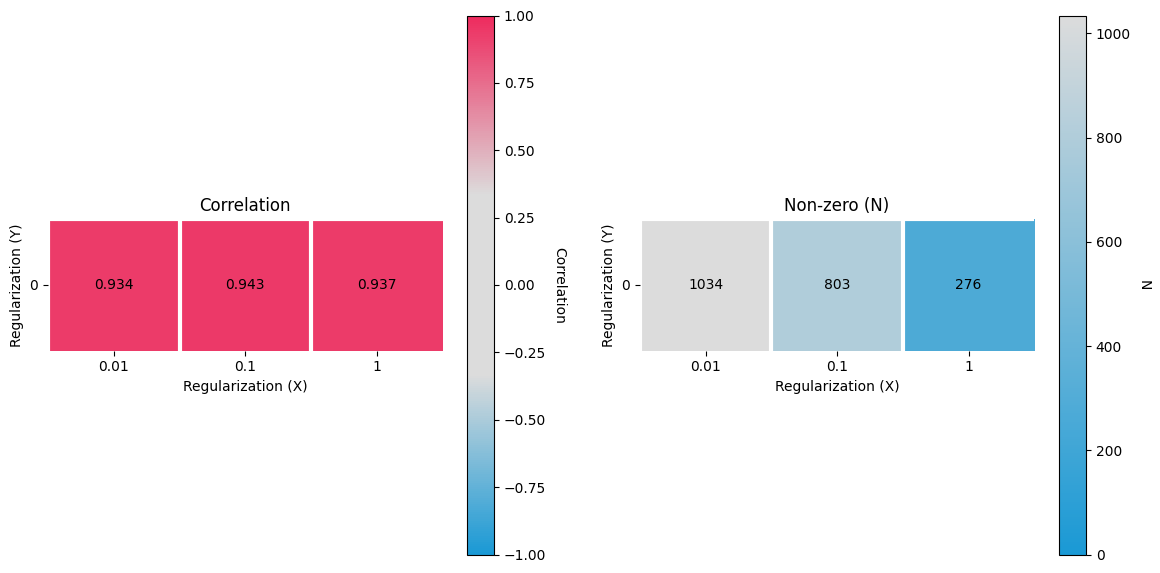

In [68]:
# Fit k-Fold CV to data. Broadly sweep through regularization values to find a good range.
in_data = cell_raw_data
out_data = cell_embedding

best_regularizer, correlations, norms = reasoning.sparse_cca_kfold_cv(in_data, out_data, 
                                                                      lambdaxs = [10**i for i in range(-2,1,1)], lambdays = [0], 
                                                                     dev = dev)

reasoning.plot_kfold_regularization(correlations, norms);

The appropriate regularization parameter appears to be $\lambda = 1 \times 10^{-2}$. We will use this value going forward.

### Fitting sCCA Models:
For illustration, we will fit a model with two components for each of the hop distances. The class for sparse CCA models are in `reasoning/cca_model`. The basic class for fitting a model is `L0SparseCCA`, which is defined:
```Python
class L0SparseCCA:
    """Class for estimating the Sparse CCA method.
    """
    def __init__(self, C: Optional[int], lambdas: Tuple[float, float], ds: Tuple[int, int],
            priors: Optional[Tuple[np.ndarray, np.ndarray]] = None, sigma: Optional[float] = 1e-1, r: Optional[float] = 0.25,
            optimizer: Optional[torch.optim.Optimizer] = torch.optim.Adam, display: Optional[bool] = True, correlation_threshold: Optional[int] = None,
            learning_rate: Optional[float] = 1e-3, max_iters: Optional[int] = 250, tol: Optional[float] = 1e-10, batch_size: Optional[int] = 4096,
            dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            ):
        """
        Args:
            C: number of canonical vectors to compute for each value
            lambdas: tuple of regularizaton parameters for the input and output values, respectively 
            ds: tuple of dimensions of the input data
            priors: priors over the computed canonical vectors. Estimated using CCA or PCA (see the fit function) 
            sigma: width of probability model used in reparametrization trick  
            r: sparsity fraction parameter applied to priors  
            optimizer: choice of optimizer used to train moodels
            display: display training progressbar 
            correlation_threshold: minimum threshold for correlation to reach
            learning_rate: step size for each training step
            max_iters: maximum number of training iterations
            tol: tolerance for training loss changes
            batch_size: batch size used in training model 
            dev: device on which the CCA model is trained
        """
```
(See `SORBET/reasoning/cca_model/model.py:26-51`).

This should be fit for each hop-distance. The model is implemented in the style of `sklearn` models, with `fit` and `fit_transform` methods.

**Data:** To help identify the adjacent cells paired with an embedding for each hop distance, the function `reasoning.preprocess_graph_structured_data` provides a quick technique (see `SORBET/reasoning/graph_cca.py:29-44`).

**n.b.** The matrices can become quite large for 2 and 3 hops. As such, large amounts of memory may be used. 

Fitting C2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.63it/s]


Computed CCA Models for No Hops
(192804, 960) (192804, 96)
float64 float64


Fitting C2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


Computed CCA Models for 1 Hops
(363568, 960) (363568, 96)
float64 float64


Fitting C2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:44<00:00,  2.85s/it]


Computed CCA Models for 2 Hops
(511346, 960) (511346, 96)
float64 float64


Fitting C2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:05<00:00,  3.65s/it]


Computed CCA Models for 3 Hops


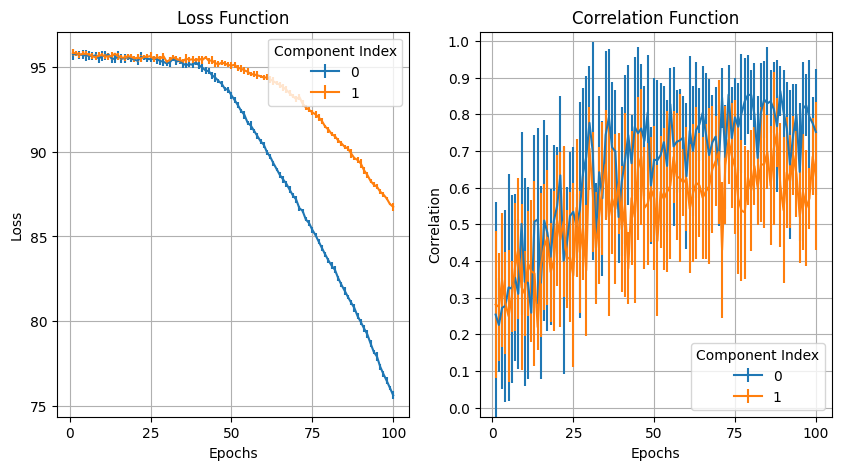

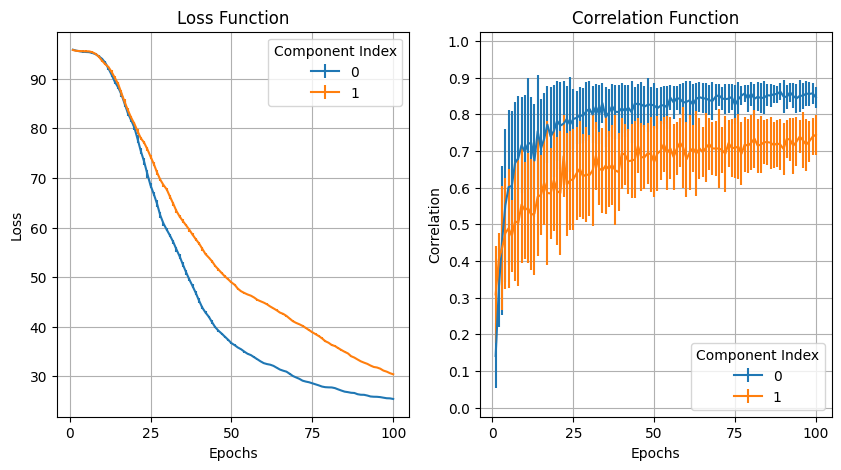

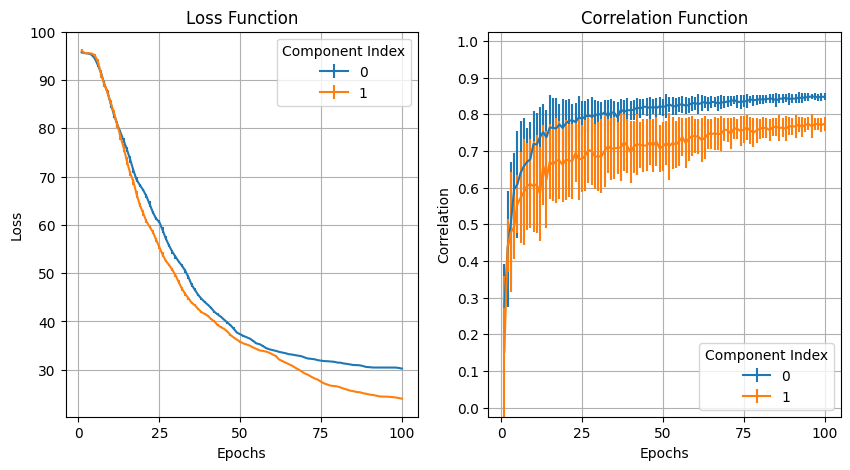

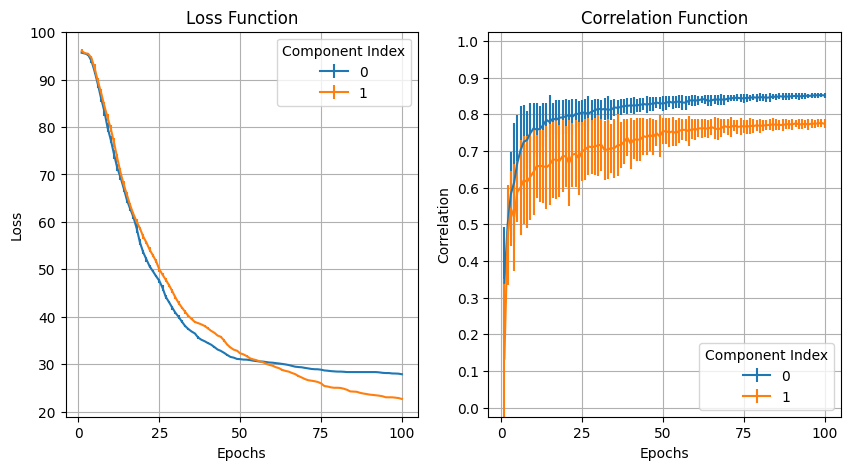

In [75]:
C_components = 2 # Number of components to fit in each CCA model. 
max_iters = 100
batch_size = 4096
learning_rate = 1e-3
ds = [cell_raw_data.shape[1], cell_embedding.shape[1]]
chosen_lambdas = [0.1,0] # Chosen based on cross validation results above
display = True

dev = torch.device("cuda:2")

def fit_model(in_data, out_data, model_fpath = None, model_fit_fpath = None):
    model = reasoning.L0SparseCCA(C = C_components, lambdas=chosen_lambdas, ds=ds, 
                                  learning_rate=learning_rate, max_iters=max_iters, batch_size=batch_size, 
                                  display=display, dev=dev, correlation_threshold=0.0, tol=1e-20)
    model.fit(in_data, out_data)

    if model_fpath:
        reasoning.save_cca_model(model, model_fpath)

    if model_fit_fpath:
        fig = model.plot_fit()
        fig.savefig(f'{model_fit_fpath}.svg', bbox_inches='tight', transparent=True, dpi=720)
        fig.savefig(f'{model_fit_fpath}.png', bbox_inches='tight', transparent=True)


cca_models_dirpath = os.path.join(record.statistics_dir, "cca_models")
if not os.path.exists(cca_models_dirpath): os.makedirs(cca_models_dirpath)
model_fpath_fmt = os.path.join(cca_models_dirpath, "k_{0}_polarity_{1}.p")

cca_model_fits_dirpath = os.path.join(record.plots_dir, "cca_model_fits")
if not os.path.exists(cca_model_fits_dirpath): os.makedirs(cca_model_fits_dirpath)
model_fit_fpath_fmt = os.path.join(cca_model_fits_dirpath, "k_{0}_polarity_{1}")

############################################
# Fit CCA over no hops (i.e. cell identity):
############################################
fit_model(cell_raw_data, cell_embedding, 
          model_fpath = model_fpath_fmt.format(0, "all"), model_fit_fpath = model_fit_fpath_fmt.format(0, "all"))

print("Computed CCA Models for No Hops")

############################################
# Fit CCA over valid hops (i.e. 1/2/3 hops):
############################################
metadata_files = learning.make_subgraph_metadata("data/tutorial/processed_subgraphs/znormalized/")
for nhops in range(1,4):
    if nhops < 1: continue
    cca_data = reasoning.preprocess_graph_structured_data(os.path.join(metadata_files.processed_dirpath, "graphs_py"),
                                                          cell_embedding, cell_subgraphs_keys, cell_indices, nhops=nhops)

    print(cca_data.in_array.shape, cca_data.out_array.shape)
    print(cca_data.in_array.dtype, cca_data.out_array.dtype)
    fit_model(cca_data.in_array, cca_data.out_array, model_fpath = model_fpath_fmt.format(nhops, "all"), model_fit_fpath = model_fit_fpath_fmt.format(nhops, "all"))

    graph_indexing_inv = {v:k for k,v in cca_data.indexing.graph_indexing.items()}
    convert_to_label = lambda graph_index: graph_phenotype_labels[graph_indexing_inv[graph_index]]
    _labels = np.array([convert_to_label(a[2]) for a in cca_data.indexing.row_indexing])
    
    print(f'Computed CCA Models for {nhops} Hops')

marker_lst = cca_data.indexing.in_col_indexing

We then compute and plot the marker norms associated with 

In [77]:
canonical_vectors = list()
for nhops in range(4):
    model = reasoning.load_cca_model(model_fpath_fmt.format(nhops, "all"))
    a, _ = model.canonical_weight_vectors
    canonical_vectors.append(a)

canonical_vectors = np.vstack(canonical_vectors)
canonical_vectors.shape

(8, 960)

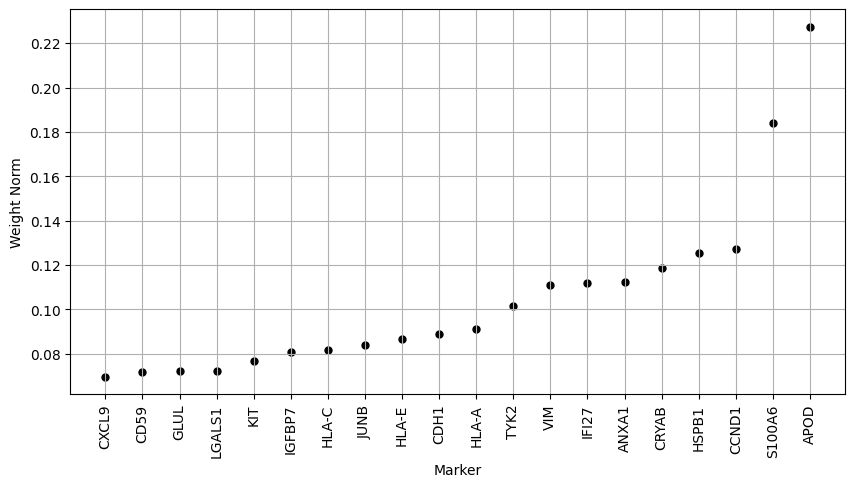

In [90]:
marker_lst = cca_data.indexing.in_col_indexing

canonical_vectors[np.abs(canonical_vectors) < 1e-16] = 0

canonical_vectors_means = np.mean(np.abs(canonical_vectors), axis=0)
sorted_indices = np.argsort(canonical_vectors_means)

N = 20

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(np.arange(N) + 1, canonical_vectors_means[sorted_indices][-N:], c='k', s=25)
ax.set_xlabel("Marker")
ax.set_ylabel("Weight Norm")
ax.set_xticks(np.arange(N) + 1, [marker_lst[sii].split("_")[-1] for sii in sorted_indices][-N:], rotation=90)
ax.grid(True)